# 데이터셋 준비하기

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tqdm import tqdm
import os, shutil
import re

In [23]:
!ls

data  jonghee.ipynb  tf_image_classification.ipynb


In [5]:
train_path = './data/train'
val_path = './data/val'
test_path = './data/test'

In [32]:
def 데이터_전처리(path):
    
    files = os.listdir(path)
    
    for file in tqdm(files):
        
        # txt파일부터 삭제
        if file.split('.')[-1] == 'txt':
            os.remove(path+'/'+file)
        
        # jpg파일은 클래스별 파일로 이동
        else:
            p = re.compile(r'[_]\d*[_]')
            m = p.search(file)
            num = m.group()[1:-1]
            if not os.path.exists(path+'/'+num):
                os.makedirs(path+'/'+num)
            shutil.move(path+'/'+file, path+'/'+num+'/'+file)
            
    print('완료!')

In [33]:
데이터_전처리(test_path)

100%|██████████| 1740/1740 [00:00<00:00, 19450.68it/s]

완료!


In [35]:
데이터_전처리(val_path)

100%|██████████| 3642/3642 [00:00<00:00, 25840.53it/s]

완료!


In [36]:
데이터_전처리(train_path)

100%|██████████| 31917/31917 [00:01<00:00, 25043.77it/s]

완료!


In [7]:
# 클래스의 개수
class_num = len(os.listdir(train_path))
class_num

103

# 케라스 내장 모델 list

https://keras.io/api/applications/

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [4]:
mb2 = tf.keras.applications.MobileNetV2(input_shape=(640,640,3),
                                        include_top=False,
                                        weights="imagenet")

/home/ubuntu/anaconda3/envs/jh_tf_36/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [5]:
mb2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 640, 640, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 641, 641, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 320, 320, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 320, 320, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [128]:
# from tensorflow.keras import models
# from tensorflow.keras import layers

# model = models.Sequential()
# model.add(mb2)
# model.add(layers.Flatten())
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.Dense(class_num, activation='softmax'))

In [8]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(mb2)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(class_num, activation='softmax'))

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 20, 20, 1280)      2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 512000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262144512 
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 103)               52839     
Total params: 264,457,383
Trainable params: 264,422,247
Non-trainable params: 35,136
_________________________________________________________________


# 동결하고 훈련

https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/guide/keras/transfer_learning.ipynb?hl=ko#scrollTo=736c99aea690

In [130]:
print('mb2를 동결하기 전 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

mb2를 동결하기 전 훈련되는 가중치의 수: 166


In [131]:
# block_16_expand 전까지 동결하자.

mb2.trainable = True

set_trainable = False
for layer in mb2.layers:
    if layer.name == 'block_16_expand':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [132]:
print('mb2를 동결한 후 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

mb2를 동결한 후 훈련되는 가중치의 수: 22


In [133]:
#  컴파일 단계 후에 trainable 속성을 변경하면 반드시 모델을 다시 컴파일해야 한다.

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers


train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')


# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(train_path, # 타깃 디렉터리
                                                    target_size=(640, 640),
                                                    batch_size=32,
                                                    class_mode='sparse')
'''
InvalidArgumentError:  Can not squeeze dim[1], expected a dimension of 1, got 103 	 [[node metrics/acc/Squeeze (defined at <ipython-input-94-e3d02e874b63>:50) ]] [Op:__inference_distributed_function_100686]
에러 해결!
https://stackoverflow.com/questions/49083984/valueerror-can-not-squeeze-dim1-expected-a-dimension-of-1-got-3-for-sparse
'''


validation_generator = test_datagen.flow_from_directory(val_path,
                                                        target_size=(640, 640),
                                                        batch_size=8,
                                                        class_mode='sparse')


callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=5,),
                 keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5,)]


model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['acc'])


history = model.fit_generator(train_generator,
                              steps_per_epoch=8, # 제너레이터로부터 얼마나 많은 샘플을 뽑을 것인지.
                              epochs=200,
                              validation_data=validation_generator,
                              validation_steps=2,
                              verbose=2,
                              callbacks=callbacks_list)

Found 15883 images belonging to 103 classes.
Found 1821 images belonging to 103 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/200
8/8 - 31s - loss: 5.1265 - acc: 0.0352 - val_loss: 5.0593 - val_acc: 0.0000e+00
Epoch 2/200
8/8 - 30s - loss: 4.7229 - acc: 0.0508 - val_loss: 5.0286 - val_acc: 0.0000e+00
Epoch 3/200
8/8 - 32s - loss: 4.1413 - acc: 0.1641 - val_loss: 4.8527 - val_acc: 0.0625
Epoch 4/200
8/8 - 31s - loss: 3.7401 - acc: 0.2266 - val_loss: 4.5461 - val_acc: 0.1250
Epoch 5/200
8/8 - 31s - loss: 3.6447 - acc: 0.1992 - val_loss: 4.2600 - val_acc: 0.1250
Epoch 6/200
8/8 - 31s - loss: 3.2382 - acc: 0.3047 - val_loss: 3.9635 - val_acc: 0.1875
Epoch 7/200
8/8 - 31s - loss: 2.9288 - acc: 0.3398 - val_loss: 3.6863 - val_acc: 0.1875
Epoch 8/200
8/8 - 31s - loss: 2.7036 - acc: 0.4688 - val_loss: 3.4539 - val_acc: 0.2500
Epoch 9/200
8/8 - 31s - loss: 2.5201 - acc: 0.4883 - val_loss: 3.3088 - val_acc: 0.3125
Epoch 10/200
8/8 - 28

In [136]:
history.history

{'loss': [5.12647020816803,
  4.722870469093323,
  4.141320466995239,
  3.740058571100235,
  3.6446752548217773,
  3.238192319869995,
  2.928788423538208,
  2.7036374509334564,
  2.5200681388378143,
  1.9886567349129536,
  2.129666179418564,
  2.072603538632393,
  1.9249906986951828,
  1.6961473226547241,
  1.5576536804437637,
  1.3663685098290443,
  1.2609866857528687,
  1.3196111470460892,
  1.1273635849356651,
  1.2050056755542755,
  0.9411175829298952,
  1.1940297037363052,
  1.0583171173930168,
  0.9517195522785187,
  0.9798691719770432,
  0.9773151129484177,
  0.8386290967464447,
  0.7820166051387787],
 'acc': [0.03515625,
  0.05078125,
  0.1640625,
  0.2265625,
  0.19921875,
  0.3046875,
  0.33984375,
  0.46875,
  0.48828125,
  0.6212766,
  0.5703125,
  0.58203125,
  0.64453125,
  0.6640625,
  0.70703125,
  0.7734375,
  0.78125,
  0.76953125,
  0.82421875,
  0.796875,
  0.8425532,
  0.79296875,
  0.83203125,
  0.8828125,
  0.859375,
  0.84765625,
  0.88671875,
  0.90625],
 'val_

In [137]:
history.model

### 결과 시각화

In [139]:
help(history.history)

Help on dict object:

class dict(object)
 |  dict() -> new empty dictionary
 |  dict(mapping) -> new dictionary initialized from a mapping object's
 |      (key, value) pairs
 |  dict(iterable) -> new dictionary initialized as if via:
 |      d = {}
 |      for k, v in iterable:
 |          d[k] = v
 |  dict(**kwargs) -> new dictionary initialized with the name=value pairs
 |      in the keyword argument list.  For example:  dict(one=1, two=2)
 |  
 |  Methods defined here:
 |  
 |  __contains__(self, key, /)
 |      True if D has a key k, else False.
 |  
 |  __delitem__(self, key, /)
 |      Delete self[key].
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(...)
 |      x.__getitem__(y) <==> x[y]
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize s

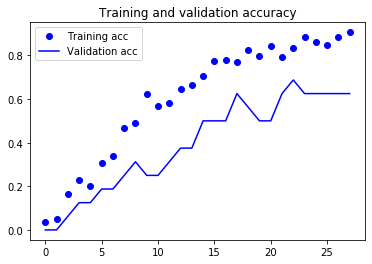

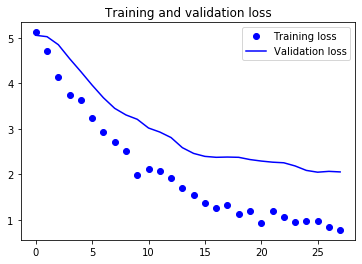

In [143]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

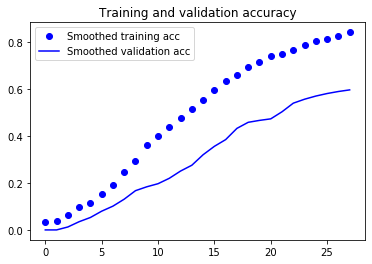

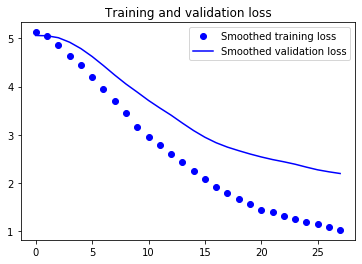

In [144]:
# 지수이동평균으로 더 보기 좋은 곡선

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 동결 풀고 제대로 학습

In [146]:
#  컴파일 단계 후에 trainable 속성을 변경하면 반드시 모델을 다시 컴파일해야 한다.

# 동결 풂
mb2.trainable = True

with tf.device('/device:GPU:1'):
    
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=15,),
                     keras.callbacks.ModelCheckpoint(filepath='mb2.h5', monitor='val_loss',save_best_only=True,),
                     keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=15,)]


    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizers.Adam(lr=3e-4), # https://www.jeremyjordan.me/nn-learning-rate/
                  metrics=['acc'])


    history = model.fit_generator(train_generator,
                                  steps_per_epoch=8, # 제너레이터로부터 얼마나 많은 샘플을 뽑을 것인지.
                                  epochs=300,
                                  validation_data=validation_generator,
                                  validation_steps=2,
                                  verbose=2,
                                  callbacks=callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/300
8/8 - 49s - loss: 2.3908 - acc: 0.4688 - val_loss: 13.6311 - val_acc: 0.0000e+00
Epoch 2/300
8/8 - 68s - loss: 2.4771 - acc: 0.4844 - val_loss: 11.8053 - val_acc: 0.0000e+00
Epoch 3/300
8/8 - 66s - loss: 1.9401 - acc: 0.5820 - val_loss: 10.9940 - val_acc: 0.0000e+00
Epoch 4/300
8/8 - 68s - loss: 1.3213 - acc: 0.7305 - val_loss: 9.8301 - val_acc: 0.0000e+00
Epoch 5/300
8/8 - 67s - loss: 1.1192 - acc: 0.8164 - val_loss: 9.4578 - val_acc: 0.0000e+00
Epoch 6/300
8/8 - 31s - loss: 0.9698 - acc: 0.8359 - val_loss: 13.1678 - val_acc: 0.0000e+00
Epoch 7/300
8/8 - 31s - loss: 0.7000 - acc: 0.8984 - val_loss: 10.5347 - val_acc: 0.0000e+00
Epoch 8/300
8/8 - 43s - loss: 0.5491 - acc: 0.9492 - val_loss: 8.3264 - val_acc: 0.0000e+00
Epoch 9/300
8/8 - 68s - loss: 0.5342 - acc: 0.9219 - val_loss: 6.9408 - val_acc: 0.1250
Epoch 10/300
8/8 - 66s - loss: 0.4820 - acc: 0.9258 - val_loss: 5.9744 - val_acc:

### 결과 시각화

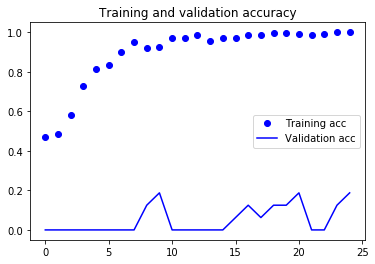

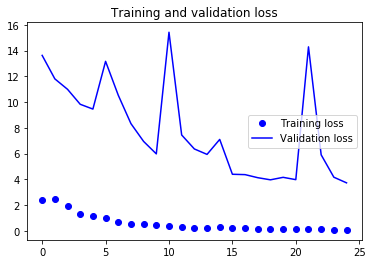

In [147]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

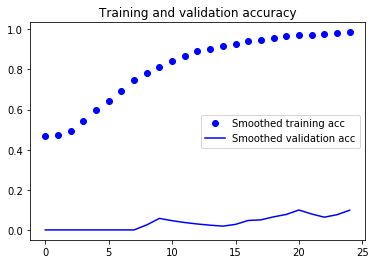

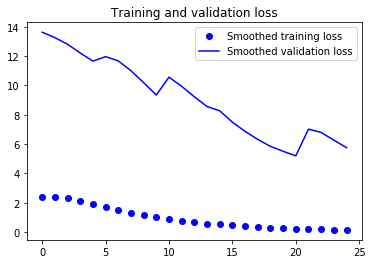

In [148]:
# 지수이동평균으로 더 보기 좋은 곡선

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 동결 안하고 훈련!

In [10]:
#  컴파일 단계 후에 trainable 속성을 변경하면 반드시 모델을 다시 컴파일해야 한다.

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers


train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')


# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(train_path, # 타깃 디렉터리
                                                    target_size=(640, 640),
                                                    batch_size=32,
                                                    class_mode='sparse')


validation_generator = test_datagen.flow_from_directory(val_path,
                                                        target_size=(640, 640),
                                                        batch_size=8,
                                                        class_mode='sparse')


callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=30,),
                  keras.callbacks.ModelCheckpoint(filepath='mb2.h5', monitor='val_loss',save_best_only=True,),
                  keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=10,)]


model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['acc'])


history = model.fit_generator(train_generator,
                              steps_per_epoch=8, # 제너레이터로부터 얼마나 많은 샘플을 뽑을 것인지.
                              epochs=500,
                              validation_data=validation_generator,
                              validation_steps=2,
                              verbose=2,
                              callbacks=callbacks_list)

Found 15883 images belonging to 103 classes.
Found 1821 images belonging to 103 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 8 steps, validate for 2 steps
Epoch 1/500
8/8 - 48s - loss: 4.9111 - acc: 0.0664 - val_loss: 6.4515 - val_acc: 0.0000e+00
Epoch 2/500
8/8 - 65s - loss: 4.3481 - acc: 0.1328 - val_loss: 6.1995 - val_acc: 0.0000e+00
Epoch 3/500
8/8 - 67s - loss: 3.7364 - acc: 0.2109 - val_loss: 5.4039 - val_acc: 0.0625
Epoch 4/500
8/8 - 66s - loss: 3.1902 - acc: 0.3359 - val_loss: 4.7040 - val_acc: 0.0625
Epoch 5/500
8/8 - 66s - loss: 2.7605 - acc: 0.4258 - val_loss: 4.3467 - val_acc: 0.1875
Epoch 6/500
8/8 - 67s - loss: 2.1430 - acc: 0.5625 - val_loss: 3.9203 - val_acc: 0.3125
Epoch 7/500
8/8 - 66s - loss: 1.8538 - acc: 0.6328 - val_loss: 3.5649 - val_acc: 0.3750
Epoch 8/500
8/8 - 67s - loss: 1.9060 - acc: 0.5898 - val_loss: 3.2653 - val_acc: 0.3750
Epoch 9/500
8/8 - 66s - loss: 1.5

Epoch 87/500
8/8 - 67s - loss: 0.0592 - acc: 0.9961 - val_loss: 0.3011 - val_acc: 0.9375
Epoch 88/500
8/8 - 41s - loss: 0.0801 - acc: 0.9922 - val_loss: 0.2975 - val_acc: 0.9375
Epoch 89/500
8/8 - 67s - loss: 0.0706 - acc: 1.0000 - val_loss: 0.2934 - val_acc: 0.9375
Epoch 90/500
8/8 - 68s - loss: 0.0615 - acc: 0.9883 - val_loss: 0.2894 - val_acc: 0.9375
Epoch 91/500
8/8 - 68s - loss: 0.0715 - acc: 0.9922 - val_loss: 0.2859 - val_acc: 0.9375
Epoch 92/500
8/8 - 66s - loss: 0.0688 - acc: 0.9961 - val_loss: 0.2829 - val_acc: 0.9375
Epoch 93/500
8/8 - 68s - loss: 0.0462 - acc: 1.0000 - val_loss: 0.2803 - val_acc: 0.9375
Epoch 94/500
8/8 - 67s - loss: 0.0459 - acc: 0.9961 - val_loss: 0.2780 - val_acc: 0.9375
Epoch 95/500
8/8 - 66s - loss: 0.0517 - acc: 0.9961 - val_loss: 0.2754 - val_acc: 0.9375
Epoch 96/500
8/8 - 67s - loss: 0.0496 - acc: 0.9922 - val_loss: 0.2726 - val_acc: 0.9375
Epoch 97/500
8/8 - 68s - loss: 0.0910 - acc: 0.9844 - val_loss: 0.2674 - val_acc: 0.9375
Epoch 98/500
8/8 - 67

Epoch 179/500
8/8 - 67s - loss: 0.0559 - acc: 0.9883 - val_loss: 0.1158 - val_acc: 0.9375
Epoch 180/500
8/8 - 75s - loss: 0.0562 - acc: 0.9961 - val_loss: 0.1150 - val_acc: 0.9375
Epoch 181/500
8/8 - 67s - loss: 0.0307 - acc: 1.0000 - val_loss: 0.1128 - val_acc: 0.9375
Epoch 182/500
8/8 - 67s - loss: 0.0453 - acc: 0.9922 - val_loss: 0.1124 - val_acc: 0.9375
Epoch 183/500
8/8 - 68s - loss: 0.0431 - acc: 0.9922 - val_loss: 0.1124 - val_acc: 0.9375
Epoch 184/500
8/8 - 32s - loss: 0.0440 - acc: 0.9922 - val_loss: 0.1137 - val_acc: 0.9375
Epoch 185/500
8/8 - 31s - loss: 0.0389 - acc: 0.9961 - val_loss: 0.1130 - val_acc: 0.9375
Epoch 186/500
8/8 - 43s - loss: 0.0428 - acc: 0.9961 - val_loss: 0.1122 - val_acc: 0.9375
Epoch 187/500
8/8 - 31s - loss: 0.0363 - acc: 0.9961 - val_loss: 0.1126 - val_acc: 0.9375
Epoch 188/500
8/8 - 32s - loss: 0.0276 - acc: 0.9961 - val_loss: 0.1135 - val_acc: 0.9375
Epoch 189/500
8/8 - 31s - loss: 0.0317 - acc: 0.9961 - val_loss: 0.1142 - val_acc: 0.9375
Epoch 190/

8/8 - 31s - loss: 0.0274 - acc: 0.9961 - val_loss: 0.0065 - val_acc: 1.0000
Epoch 271/500
8/8 - 43s - loss: 0.0189 - acc: 1.0000 - val_loss: 0.0064 - val_acc: 1.0000
Epoch 272/500
8/8 - 66s - loss: 0.0335 - acc: 0.9961 - val_loss: 0.0064 - val_acc: 1.0000
Epoch 273/500
8/8 - 66s - loss: 0.0338 - acc: 1.0000 - val_loss: 0.0063 - val_acc: 1.0000
Epoch 274/500
8/8 - 66s - loss: 0.0236 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 1.0000
Epoch 275/500
8/8 - 42s - loss: 0.0308 - acc: 1.0000 - val_loss: 0.0061 - val_acc: 1.0000
Epoch 276/500
8/8 - 67s - loss: 0.0196 - acc: 1.0000 - val_loss: 0.0060 - val_acc: 1.0000
Epoch 277/500
8/8 - 67s - loss: 0.0303 - acc: 1.0000 - val_loss: 0.0060 - val_acc: 1.0000
Epoch 278/500
8/8 - 31s - loss: 0.0252 - acc: 1.0000 - val_loss: 0.0060 - val_acc: 1.0000
Epoch 279/500
8/8 - 31s - loss: 0.0221 - acc: 1.0000 - val_loss: 0.0060 - val_acc: 1.0000
Epoch 280/500
8/8 - 31s - loss: 0.0287 - acc: 0.9961 - val_loss: 0.0060 - val_acc: 1.0000
Epoch 281/500
8/8 - 31s 

Epoch 362/500
8/8 - 31s - loss: 0.0316 - acc: 1.0000 - val_loss: 0.0058 - val_acc: 1.0000
Epoch 363/500
8/8 - 32s - loss: 0.0284 - acc: 1.0000 - val_loss: 0.0058 - val_acc: 1.0000
Epoch 364/500
8/8 - 31s - loss: 0.0399 - acc: 0.9961 - val_loss: 0.0058 - val_acc: 1.0000
Epoch 365/500
8/8 - 32s - loss: 0.0190 - acc: 1.0000 - val_loss: 0.0058 - val_acc: 1.0000


In [ ]:
import matplotlib.pyplot as plt

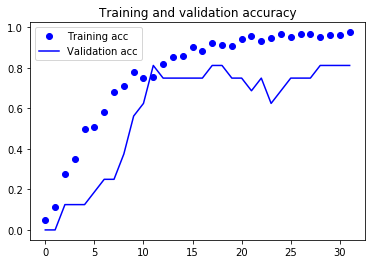

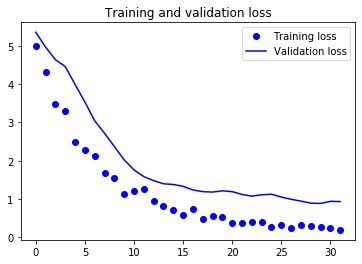

In [27]:
# 결과 시각화

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

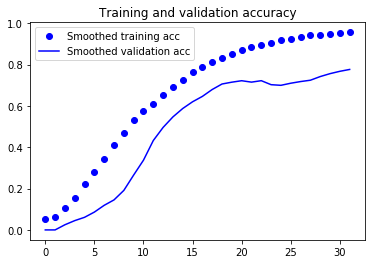

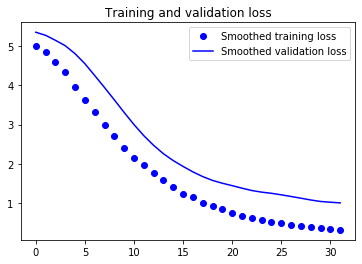

In [28]:
# 지수이동평균으로 더 보기 좋은 곡선

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 훈련된 h5모델 로드

In [6]:
model_load = keras.models.load_model("mb2_good.h5")

# 테스트 데이터에서 평가

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(640, 640),
        batch_size=8,
        class_mode='sparse')

test_loss, test_acc = model_load.evaluate_generator(test_generator, steps=8)
print('test acc:', test_acc)

Found 870 images belonging to 105 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
test acc: 0.328125
